In [1]:
import time_series2d_v2
import brownian
from importlib import reload
reload(time_series2d_v2)
reload(brownian)

from time_series2d_v2 import Collection, TimeSeries, find_ders, find_files
from brownian import make_sim_params, sim
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline


# TimeSeries class

In [2]:
# Make some fake time series data
size = 2**20  # number of points
r = 25e6  # sample rate
x = np.random.randn(size) # data axis
timeseries = TimeSeries(x, r=r)

## Raw data

In [3]:
# call the instance to return the (time, coordinate) data
timeseries()

(array([0.000000e+00, 4.000000e-08, 8.000000e-08, ..., 4.194292e-02,
        4.194296e-02, 4.194300e-02]),
 array([ 0.20913567, -1.20338173, -0.09008553, ..., -1.92702565,
         0.69085862,  0.74026621]))

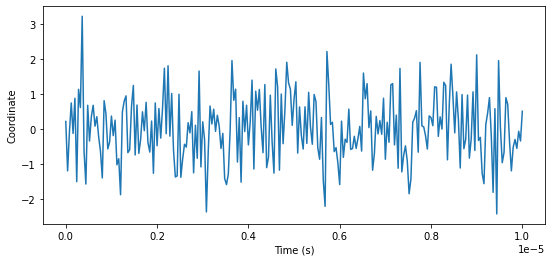

In [4]:
# Plot method for the raw coordinate data
timeseries.plot(tmin=0, tmax=1e-5);

## Bin averaging raw data

In [5]:
# Average `Npts` consecutive points (lowpass filter)
timeseries.restore() # More on this in a moment
timeseries.bin_average(Npts=10)

(array([1.800000e-07, 5.800000e-07, 9.800000e-07, ..., 4.194178e-02,
        4.194218e-02, 4.194258e-02]),
 array([ 0.38368749, -0.13163467, -0.25898665, ..., -0.42386711,
         0.03908306,  0.30101143]))

Automatically updated
     size: 104857, sampling rate: 2.5 MHz


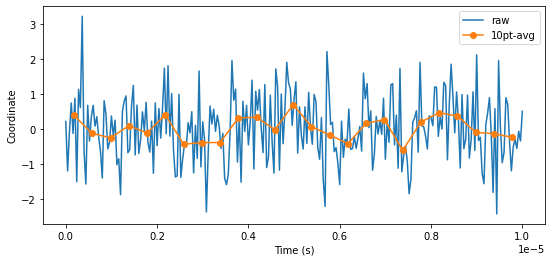

In [6]:
# update the timeseires with the smoothed data by setting `inplace=True`
fig, ax = timeseries.plot(tmin=0, tmax=1e-5, label='raw');
Npts = 10
timeseries.restore()
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.plot(ax=ax, tmin=0, tmax=1e-5, marker="o", label=f"{Npts}pt-avg")
ax.legend()
print("Automatically updated")
print(f"     size: {timeseries.size}, sampling rate: {timeseries.r/1e6} MHz")

size: 1048576, sampling rate: 25.0 MHz


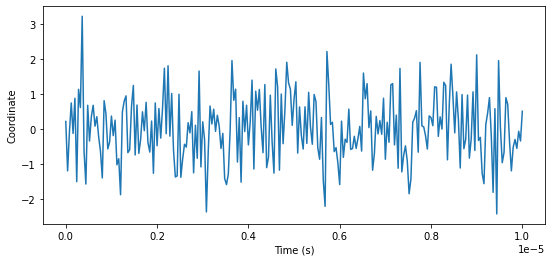

In [7]:
# Restore the raw data
timeseries.restore()
timeseries.plot(tmin=0, tmax=1e-5, label='raw')
print(f"size: {timeseries.size}, sampling rate: {timeseries.r/1e6} MHz")

## Histograms (HIST)

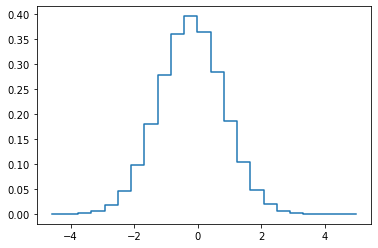

In [8]:
# Comute the histogram and store the data in the `bins` and `hist` attributes
timeseries.HIST(Nbins=25)
plt.step(timeseries.bins, timeseries.hist);

Average over 4 histograms, each from 0.01 seconds of data


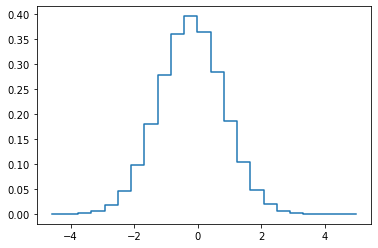

In [9]:
# Set 'taumax' to partition the data in sets of length taumax seconds
# and averag the histogram over the partitions
taumax=10e-3
timeseries.HIST(Nbins=25, taumax=taumax)
print(f"Average over {timeseries.Navg_hist} histograms, each from {taumax} seconds of data")
plt.step(timeseries.bins, timeseries.hist);

## Power spctral density (PSD)

Average over 4 spectra, each from 0.01 seconds of data


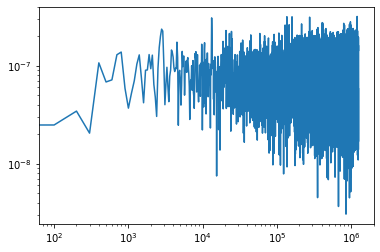

In [10]:
# restore raw data
timeseries.restore()
# set up analysis parameters
Npts = 10
taumax = 10e-3
# analysis 
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.PSD(taumax=taumax)
#reporting
print(f"Average over {timeseries.Navg_psd} spectra, each from {taumax} seconds of data")
plt.loglog(timeseries.freq, timeseries.psd)

## Mean-squared displacement(MSD)

Average over 2 MSDs, each from 0.02 seconds of data


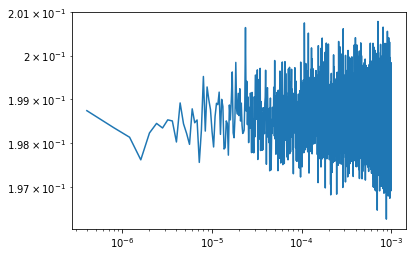

In [11]:
# As above...
timeseries.restore()
Npts = 10
taumax = 20e-3
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.MSD(taumax=taumax)
print(f"Average over {timeseries.Navg_msd} MSDs, each from {round(taumax,4)} seconds of data")
# Rule of thumb, good statistics up to  ~5% of record length
mask = timeseries.tmsd < taumax*0.05
plt.loglog(timeseries.tmsd[mask], timeseries.msd[mask])

## Autocorrelation function (ACF)

Average over 2 ACFs, each from 0.02 seconds of data


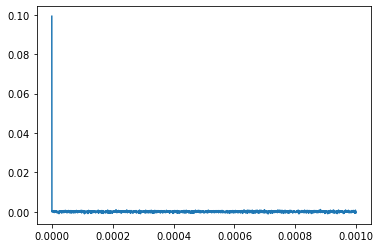

In [12]:
# As above...
timeseries.restore()
Npts = 10
taumax = 20e-3
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.ACF(taumax=taumax)
print(f"Average over {timeseries.Navg_msd} ACFs, each from {round(taumax,4)} seconds of data")
# Rule of thumb, good statistics up to  ~5% of record length
mask = timeseries.tacf < taumax*0.05
plt.plot(timeseries.tacf[mask], timeseries.acf[mask])

## Alan variance (AVAR) and normal variance (NVAR)

Average over 1 ACFs, each from 0.02 seconds of data


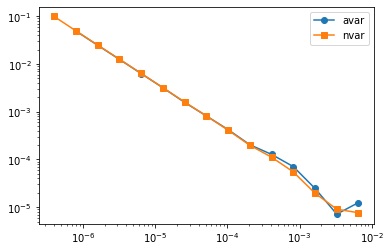

In [13]:
# As above...
timeseries.restore()
Npts = 10
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.AVAR(func=np.mean, octave=True) # Alan variance of mean, octave sampled
timeseries.NVAR(func=np.mean, octave=True) # Normal variance of mean, octave sampled
print(f"Average over {timeseries.Navg_avar} ACFs, each from {round(taumax,4)} seconds of data")

plt.loglog(timeseries.tavar, timeseries.avar, marker="o", label="avar")
plt.loglog(timeseries.tnvar, timeseries.nvar, marker="s", label="nvar")
plt.legend()

# Find TDMS data

Given a data-drive mount mount point, the convenience functions `find_ders` and `find_files` may be used to locate desiered data files.

In [14]:
base_der = "/mnt/ext/data" # mount point

In [15]:
date_ders = find_ders(base_der) # Experimental data is organized by date collected
date_ders

['/mnt/ext/data/20201103',
 '/mnt/ext/data/20201111',
 '/mnt/ext/data/20201130',
 '/mnt/ext/data/20201204',
 '/mnt/ext/data/20201214',
 '/mnt/ext/data/20210113',
 '/mnt/ext/data/20210114',
 '/mnt/ext/data/20210120',
 '/mnt/ext/data/20210121',
 '/mnt/ext/data/20210202',
 '/mnt/ext/data/20210203',
 '/mnt/ext/data/20210208',
 '/mnt/ext/data/20210210',
 '/mnt/ext/data/20210408',
 '/mnt/ext/data/20210409',
 '/mnt/ext/data/20210412',
 '/mnt/ext/data/20210419']

In [16]:
date_der = date_ders[-1]
date = os.path.basename(date_der)
run_ders = find_ders(date_der) # Further organized by a 'run name'
run_ders

['/mnt/ext/data/20210419/bead1']

In [17]:
files = find_files(run_ders[0])  # Each run conssts of a set of trials
files

['/mnt/ext/data/20210419/bead1/trial_0.tdms',
 '/mnt/ext/data/20210419/bead1/trial_1.tdms']

In [18]:
file = files[0] # this is an example file.

# Collection class

Each TDMS file consists of `Nrecord` X-Y position records, each collected at a sampling rate `r` as well as start-of-record timestamps, forward/backward laser powers, air temperatures, heater currents, and heater voltages. The `Collection` class makes this data accessible and computable. Each instance of `Collection` has an attribute `collection` that is a list of `TimeSeries` objects. There is one `TimeSeries` object for each record of a given coordinate `coord`. 

In [19]:
X = Collection(file, coord="x")
Y = Collection(file, coord="y")

In [20]:
# Number of records per coordinate, record size, sample rate (Hz), and bead radius
print(f"Nrecords: {X.Nrecords}, record size: {X.size}, sampling rate {X.r/1e6} MHz, bead radius {X.R/2*1e6} um")

Nrecords: 44, record size: 1048576, sampling rate 25.0 MHz, bead radius 1.585 um


## Timestamps marking the start time of each record

In [21]:
X.t0s # get all time stamps (seconds)

array([0.        , 0.04201604, 0.08403248, 0.126049  , 0.16806836,
       0.21008468, 0.25210148, 0.29411696, 0.33613536, 0.37815204,
       0.42016736, 0.46218612, 0.50420288, 0.54622   , 0.58823632,
       0.63025152, 0.67226992, 0.71428596, 0.75630352, 0.79832036,
       0.84033716, 0.88235248, 0.92436884, 0.96638768, 1.00840208,
       1.05041572, 1.09243812, 1.13445492, 1.17647204, 1.21848852,
       1.26050544, 1.30252228, 1.3445392 , 1.38655584, 1.42857312,
       1.47058948, 1.51260512, 1.55462324, 1.5966384 , 1.6386568 ,
       1.68067124, 1.7226906 , 1.76470788, 1.8067216 ])

In [22]:
len(X.t0s) # There is one timestamp for each recors

44

In [23]:
# Timestamp intervals
intervals = np.diff(X.t0s)
print(f"timing accuracy: {round(np.std(intervals)*1e6 ,2)} us")

timing accuracy: 1.59 us


## Laser power, air temperature, heater current, and heater voltage

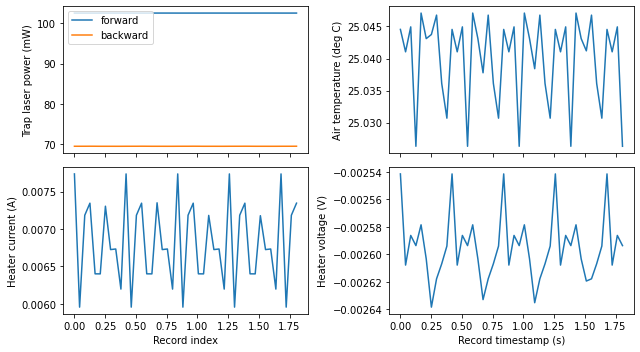

In [24]:
# Note: Could also use Y collection for access to the same data
# Each chanel has one value per time step.

fig, axs = plt.subplots(2,2, sharex="col", figsize=(9, 5))

axs[0,0].plot(X.t0s, X.PDFs, label="forward")
axs[0,0].plot(X.t0s, X.PDBs, label="backward")
axs[0,0].set_ylabel("Trap laser power (mW)")
axs[0,0].legend(loc="upper left")

axs[0,1].plot(X.t0s, X.Ts)
axs[0,1].set_ylabel("Air temperature (deg C)")

axs[1,0].plot(X.t0s, X.Is)
axs[1,0].set_ylabel("Heater current (A)")
axs[1,0].set_xlabel("Record index")

axs[1,1].plot(X.t0s, X.Vs)
axs[1,1].set_ylabel("Heater voltage (V)")
axs[1,1].set_xlabel("Record timestamp (s)")
plt.tight_layout()

## Collection of TimeSeries

In [25]:
len(X.collection) # a timeseries object is created for each record

44

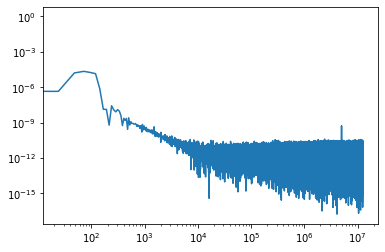

In [26]:
# Thus, all the timeseries methods are available to memebers of the collection, e.g.
x0 = X.collection[0]
plt.loglog(*x0.PSD())

## Apply

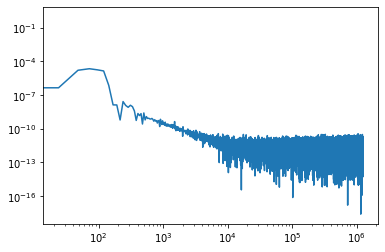

In [27]:
# Apply a timeseries restore and bin average to all members of the collection
X.apply("restore")
X.apply("bin_average", Npts=10, inplace=True)
plt.loglog(*X.collection[0].PSD()) # inspect the first member

## Average

Average over 176 spectra, each from 0.01 seconds of data


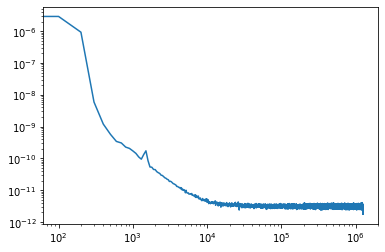

In [28]:
# Average timeseries analysis function over members of the collection
taumax = 10e-3
X.apply("restore")
X.apply("bin_average", Npts=10, inplace=True)
X.average("PSD", taumax=taumax)
print(f"Average over {X.Navg_psd} spectra, each from {taumax} seconds of data")
plt.loglog(X.freq, X.psd)

Average over 176 spectra, each from 0.01 seconds of data


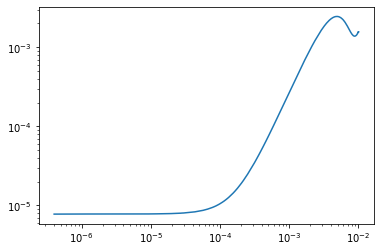

In [29]:
# Parallelized-average timeseries analysis function over members of the collection
taumax = 10e-3
n_jobs = -1 # use all avalable cores, =-2 for all-but-one 
X.apply("restore")
X.apply("bin_average", Npts=10, inplace=True)
X.average("MSD", n_jobs=n_jobs, taumax=taumax)
print(f"Average over {X.Navg_msd} spectra, each from {taumax} seconds of data")
plt.loglog(X.tmsd, X.msd)

In [30]:
# Computation time scaling with number of workers
from time import time
n_jobs_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
times = []

taumax = 10e-3
X.apply("restore")
X.apply("bin_average", Npts=10, inplace=True)

for n_jobs in n_jobs_list:
    t0 = time()
    X.average("MSD", n_jobs=n_jobs, taumax=taumax)
    t1 = time()
    times.append(t1-t0)

Asymptotic speed up factor: 7.58


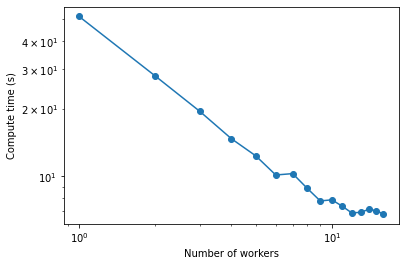

In [31]:
plt.loglog(n_jobs_list, times, marker="o")
plt.xlabel("Number of workers")
plt.ylabel("Compute time (s)")
print(f"Asymptotic speed up factor: {round(times[0]/times[-1], 2)}")

# Simulations

In [32]:
params = make_sim_params(
         K=np.array(
             [1e-6, 50e-6] # X, Y trap stiffness, N/m
             ),
         rho=1740,         # bead density, kg/m^3
         R=3.17e-6 / 2,    # bead radius, m
         T=273.15 + 25     # air temp, K
                        )
tmax = 1.0  # maximum simulation time, s
dt = 1.0/2e6  # time resolution, s

In [33]:
xs, vs, ts = sim(tmax=tmax, dt=dt, **params) # Simulation positions, velocities, and times

In [39]:
xs.shape # (time index, coordinate index), same for vs

(5000000, 2)

In [34]:
SX = TimeSeries(xs[:,0], r=1/dt)  # X coordinate position
SY = TimeSeries(xs[:,1], r=1/dt)  # Y coordinate position

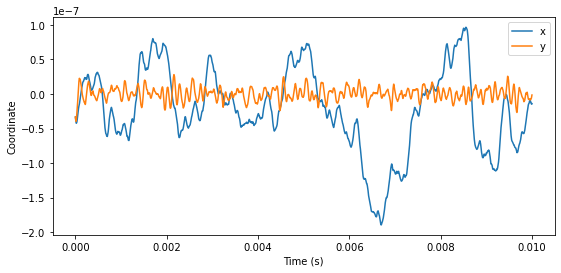

In [48]:
fig, ax = SX.plot(tmax=10e-3, label="x")
fig, ax = SY.plot(tmax=10e-3, ax=ax, label="y")
plt.legend()

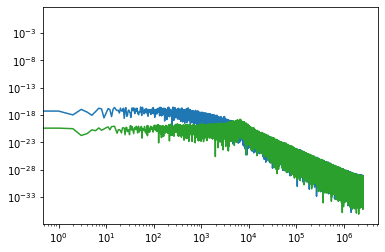

In [35]:
plt.loglog(*SX.PSD())
plt.loglog(*SY.PSD())

(3.8735262621883725e-22, 1e-13)

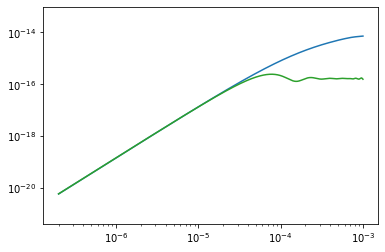

In [51]:
plt.loglog(*SX.MSD(taumax=1e-3))
plt.loglog(*SY.MSD(taumax=1e-3))
plt.ylim(top=1e-13)